In [1]:
import sqlite3 as sq
import numpy as np
import pickle
import natsort
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib import pyplot as plt
from multiprocessing.pool import Pool
import os
%matplotlib inline
def get_table(conn, table):
    out = None
    with conn:
        out = conn.execute(f"select * from {table};").fetchall();
    out_dict = {k[0]: np.array(k[1:]) for k in out}
    return (get_tau(out), out_dict)

def get_tau(table):
    return np.array(range(1, len(table[0]))) if len(table) >= 1 else None

def plot(data, key, q):
    plt.plot(data[key][0], data[key][1][q])
conn = sq.connect("../crowd.sqlite")

def list_tables(conn, filter_str: str = ""):
    with conn:
        tables = conn.execute("SELECT name FROM main.sqlite_master WHERE type='table'").fetchall();
    return list(filter(lambda t: t.find(filter_str) != -1, map(lambda t: t[0], tables)))

In [2]:
all_boxsize_tables = list_tables(conn, "multiDDM")

In [3]:
#Sort into video files
#get tables
# fits as a function of box size
video_names = set(map(lambda t: '_'.join(t.split('_')[0:-1]), all_boxsize_tables))

In [4]:
tables = {k: natsort.natsorted(filter(lambda t: t.find(f"{k}_") != -1, all_boxsize_tables)) for k in video_names}

In [5]:
data = {k: {int(e.split("_")[-1]): get_table(conn, e) for e in v} for k, v in tables.items()}

In [6]:
crowd_data = {k: v for k, v in data.items() if k.find("crowd") != -1}
running_data = {k: v for k, v in data.items() if k.find("running") != -1}

In [13]:
def brownian_isf(tau, tauc, a, b):
    return a * ( 1 - np.exp(-tau / tauc)) + b
def ballistic_isf(tau, tauc, vq, a, b):
    return a * (1 - np.sinc(vq * tau) * np.exp(- tau / tauc)) + b
brownian_bounds = ([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
ballistic_bounds = ([0, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

In [43]:
def fit(*args):
    q, tau, I, f, bounds = args[0]
    try:
        fits, errs = curve_fit(f, tau, I, bounds=bounds)
        errs = np.sqrt(np.diag(errs))
    except RuntimeError:
        return None
    else:
        #for ballistic fits the fit is vq and not v as desired
        if len(fits) == 4:
            fits[1] /= q
        return fits, errs
        
def fit_all(data, f, bounds):
    pool = Pool(20)
    return {
        video: {
            box_size: (
                d[0], 
                pool.map(fit, [
                    (q, d[0], I, f, bounds) for q, I in d[1].items()
                ])
            ) for box_size, d in dat.items()
    } for video, dat in data.items()}

In [44]:
crowd_brownian_fit = fit_all(crowd_data, brownian_isf, brownian_bounds)
crowd_ballistic_fit = fit_all(crowd_data, ballistic_isf, ballistic_bounds)
running_brownian_fit = fit_all(running_data, brownian_isf, brownian_bounds)
running_ballistic_fit = fit_all(running_data, ballistic_isf, ballistic_bounds)

Process ForkPoolWorker-18:
Process ForkPoolWorker-3:
Process ForkPoolWorker-16:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-14:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-10:
Process ForkPoolWorker-19:
Process ForkPoolWorker-12:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-13:
Process ForkPoolWorker-15:
Process ForkPoolWorker-9:
Process ForkPoolWorker-17:
Process ForkPoolWorker-11:
Process ForkPoolWorker-20:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

KeyboardInterrupt: 

Process ForkPoolWorker-34:
Process ForkPoolWorker-37:
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.2_1/Frameworks/Python.framework/Versions/3.7/lib/py

In [ ]:
def save_pickle(data, output: str):
    with open(output, "wb") as f:
        pickle.dump(data, f)

In [ ]:
def fix_formatting(data):
    return {video_name: {
        box_size: {
            (2*i + 3)/2: (e[0], np.sqrt(np.diag(e[1]))) for i, e in enumerate(d[1]) if e is not None
        } for box_size, d in dat.items()
    } for video_name, dat in data.items()}

In [ ]:
crowd_brownian_fit_formatted = fix_formatting(crowd_brownian_fit)
crowd_ballistic_fit_formatted = fix_formatting(crowd_ballistic_fit)
running_brownian_fit_formatted = fix_formatting(running_brownian_fit)
running_ballistic_fit_formatted = fix_formatting(running_ballistic_fit)

In [ ]:
save_pickle(crowd_brownian_fit_formatted, "crowd_brownian_fit.pickle")
save_pickle(crowd_ballistic_fit_formatted, "crowd_ballistic_fit.pickle")
save_pickle(running_brownian_fit_formatted, "running_brownian_fit.pickle")
save_pickle(running_ballistic_fit_formatted, "running_ballistic_fit.pickle")

In [76]:
def extract_parameter(data, param=0, remove_large_errors=False):
    return {video_name: {
        box_size: {
            q: e[0][param] for q, e in d[1].items() if not remove_large_errors or (remove_large_errors and abs(e[0][param])>= abs(e[1][param]))
        } for box_size, d in dat.items()
    } for video_name, dat in data.items()}
        

In [10]:
def load_pickle(data: str):
    with open(data, 'rb') as f:
        ret = pickle.load(f)
    return ret

In [11]:
crowd_brownian_fits = load_pickle("crowd_brownian_fit.pickle")
crowd_ballistic_fits = load_pickle("crowd_ballistic_fit.pickle")
running_brownian_fits = load_pickle("running_brownian_fit.pickle")
running_ballistic_fits = load_pickle("running_ballistic_fit.pickle")

In [78]:
crowd_brownian_tauc = extract_parameter(crowd_brownian_fits, 0, False)
running_brownian_tauc = extract_parameter(running_brownian_fits, 0, False)
crowd_ballistic_tauc = extract_parameter(crowd_ballistic_fits, 0, False)
running_ballistic_tauc = extract_parameter(running_ballistic_fits, 0, False)
crowd_ballistic_v = extract_parameter(crowd_ballistic_fits, 1, False)
running_ballistic_v = extract_parameter(running_ballistic_fits, 1, False)

In [47]:
save_pickle(crowd_brownian_tauc, "crowd_brownian_tauc.pickle")
save_pickle(running_brownian_tauc, "running_brownian_tauc.pickle")
save_pickle(crowd_ballistic_tauc, "crowd_ballistic_tauc.pickle")
save_pickle(running_ballistic_tauc, "running_ballistic_tauc.pickle")
save_pickle(crowd_ballistic_v, "crowd_ballistic_v.pickle")
save_pickle(running_ballistic_v, "running_ballistic_v.pickle")

In [79]:
brownian_tauc = {}
brownian_tauc.update(crowd_brownian_tauc)
brownian_tauc.update(running_brownian_tauc)

In [80]:
ballistic_tauc = {}
ballistic_tauc.update(crowd_ballistic_tauc)
ballistic_tauc.update(running_ballistic_tauc)

In [81]:
ballistic_v = {}
ballistic_v.update(crowd_ballistic_v)
ballistic_v.update(running_ballistic_v)

In [82]:
#save plots for box size and q 
def plot_all(data, folder: str, param: str):
    if not os.path.exists(folder):
        os.mkdir(folder)
    for video_name, dat in data.items():
        for box_size, d in dat.items():
            q_list = []
            f_list = []
            for q, f in d.items():
                q_list.append(q)
                f_list.append(f)
            plt.xlabel(r"log(q / $width_{pixel}$)")
            plt.ylabel(f"log({param})")
            plt.title(f"{param} vs q / $width_{{pixel}}$ on a log-log scale for {video_name} at box size {box_size}")
            plt.plot(np.log(q_list), np.log(f_list))
            plt.savefig(f"{folder}/{video_name}_box_size_{box_size}.png", dpi=300, pad_inches=0.8, bbox_inches = "tight")
            plt.close()

In [83]:
plot_all(brownian_tauc, "brownian_tauc", r"$\tau_c$ / (1 / fps)")
plot_all(ballistic_tauc, "ballistic_tauc", r"$\tau_c$ / (1 / fps)")
plot_all(ballistic_v, "ballistic_v", r"v / ($fps \cdot width_{pixel}^2$)")

/Users/jordan/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [ ]:
#TODO monday: add fits to db 


In [15]:
def plot_raw(data, brownian_fits, ballistic_fits, folder: str):
    if not os.path.exists(folder):
        os.mkdir(folder)
    for video_name, dat in data.items():
        if not os.path.exists(f"{folder}/{video_name}"):
            os.mkdir(f"{folder}/{video_name}")
        for box_size, d in dat.items():
            tau = d[0]
            Iq = d[1]
            for q, I in Iq.items():
                filename = f"{folder}/{video_name}/{video_name}_q_{q}_box_size_{box_size}.png"
                if os.path.exists(filename):
                    continue
                plt.xlabel(r"$\tau$ / (1 / fps)")
                plt.ylabel("F / $grayscale^2$")
                plt.title(r"F vs $\tau$ for "+ f"{video_name} at q = {q}, box size = {box_size}")
                plt.plot(tau, I, label="Raw data")
                #fits
                try:
                    brownian = brownian_fits[video_name][box_size][1][q][0]
                except KeyError:
                    pass
                else:
                    plt.plot(tau, brownian_isf(tau, *brownian),
                             label=r"Brownian ISF ($\tau_c$" + f" = {round(brownian[0], 2)}, A = {round(brownian[1], 2)}, B = {round(brownian[2], 2)})")
                try:
                    ballistic = ballistic_fits[video_name][box_size][1][q][0]
                except KeyError: pass
                else:
                    plt.plot(tau, ballistic_isf(tau, *ballistic),
                             label=r"Ballistic ISF ($\tau_c$" + f" = {round(ballistic[0], 2)}, v = {round(ballistic[1], 2)}, A = {round(ballistic[2], 2)}, B = {round(ballistic[3], 2)})")
                plt.legend(loc="lower right")
                plt.savefig(filename, dpi=300, pad_inches=0.8, bbox_inches = "tight")
                plt.close()

            

In [102]:
#plot raw images at each q box size and video crowd_data running_data

OSError: [Errno 28] No space left on device

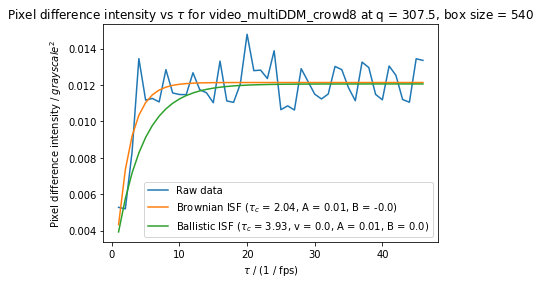

In [120]:
plot_raw(crowd_data, crowd_brownian_fits, crowd_ballistic_fits, "crowd_videos")

KeyboardInterrupt: 

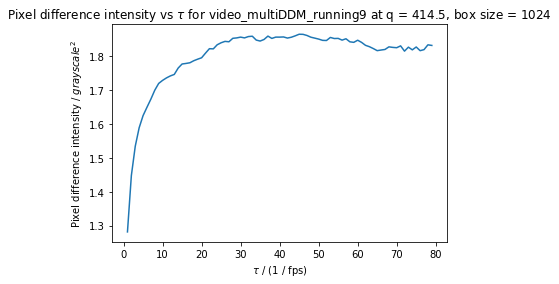

In [14]:
plot_raw(running_data, running_brownian_fits, crowd_ballistic_fits, "running_videos")